# CLIP

In [1]:
# !unzip data/archive\ \(2\).zip -d data/

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.functional as F
import tqdm

from torchvision import models
from tqdm import tqdm

Fashion Product Image Dataset: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small

In [3]:
import pandas as pd

# Load the data (the csv file has some bad lines)
df = pd.read_csv('data/myntradataset/styles.csv', on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
# Drop the rows with missing values
nan_values = df[df['productDisplayName'].isnull()].index
df = df.dropna(subset=['productDisplayName'])

nan_values

Index([3677, 14291, 17639, 22089, 23484, 37531, 40675], dtype='int64')

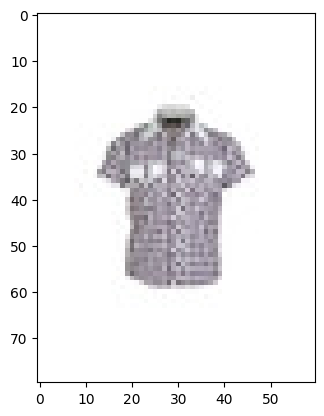

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

images = []

for img in os.listdir('data/myntradataset/images/'):
    if img.endswith('.jpg'):
        id_ = int(img.split('.')[0])

        # Check if the image is in the dataframe
        if not df[df['id'] == id_].empty and id_ not in nan_values:
            image = cv2.imread('data/myntradataset/images/' + img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

idx = np.random.randint(0, len(images))
plt.imshow(images[idx])

In [6]:
ids_ = df['id'].values
no_images = []

# Ids without images
for id_ in ids_:
    img = cv2.imread('data/myntradataset/images/' + str(id_) + '.jpg')
    if img is None:
        no_images.append(id_)

no_images

[39403, 39410, 39401, 39425, 12347]

In [7]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def preprocess_text(text):
    return tokenizer(text, return_tensors="pt", padding=True, truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class FashionDataset(Dataset):
    def __init__(self, csv_file, root_dir, train=True, transform=None):
        self.data = pd.read_csv(csv_file, on_bad_lines='skip')
        self.data = self.data.dropna(subset=['productDisplayName'])
        self.data = self.data[~self.data['id'].isin(no_images)]

        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        train_data, test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        self.data = train_data if self.train else test_data

        self.labels = preprocess_text(self.data['productDisplayName'].astype(str).values.tolist())['input_ids']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 0]) + ".jpg")
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.reshape(3, 224, 224)
        image = torch.tensor(image, dtype=torch.float32)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
from torchvision import transforms

transform = transforms.Compose([
])

train_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=True, transform=transform), batch_size=32, shuffle=True)
test_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=False, transform=transform), batch_size=32, shuffle=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1111
Test dataset size: 278


In [10]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.transformer = AutoModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 512)  # BERT outputs 768-dim embeddings

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(output.pooler_output)

In [11]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Freeze the model
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, 512)

    def forward(self, x):
        return self.model(x)

In [12]:
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    image_embeddings = nn.functional.normalize(image_embeddings, dim=1)
    text_embeddings = nn.functional.normalize(text_embeddings, dim=1)

    logits = torch.mm(image_embeddings, text_embeddings.t()) / temperature
    labels = torch.arange(len(image_embeddings)).to(image_embeddings.device)

    return nn.CrossEntropyLoss()(logits, labels) + nn.CrossEntropyLoss()(logits.t(), labels)

In [13]:
def train(text_encoder, image_encoder, dataloader, optimizer, device, epochs):
    for epoch in range(epochs):
        text_encoder.train()
        image_encoder.train()
        total_loss = 0

        for images, text in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            attention_mask = torch.ones_like(text)
            images = images.to(device)
            text = text.to(device)
            attention_mask = attention_mask.to(device)

            optimizer.zero_grad()

            text_embeddings = text_encoder(text, attention_mask)
            image_embeddings = image_encoder(images)

            loss = contrastive_loss(image_embeddings, text_embeddings)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_model = ImageEncoder().to(device)
text_model = TextEncoder().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(image_model.parameters()) + list(text_model.parameters()), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(text_model, image_model, train_dataset, optimizer, device, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 1111/1111 [04:22<00:00,  4.23it/s]


Epoch 1, Loss: 6.941022387503719


Epoch 2/10: 100%|██████████| 1111/1111 [04:23<00:00,  4.22it/s]


Epoch 2, Loss: 6.92920859325694


Epoch 3/10: 100%|██████████| 1111/1111 [04:27<00:00,  4.16it/s]


Epoch 3, Loss: 6.929220061383733


Epoch 4/10: 100%|██████████| 1111/1111 [04:25<00:00,  4.19it/s]


Epoch 4, Loss: 6.929204568682652


Epoch 5/10: 100%|██████████| 1111/1111 [04:27<00:00,  4.16it/s]


Epoch 5, Loss: 6.92920529102013


Epoch 6/10: 100%|██████████| 1111/1111 [04:21<00:00,  4.24it/s]


Epoch 6, Loss: 6.92920764344539


Epoch 7/10: 100%|██████████| 1111/1111 [04:26<00:00,  4.17it/s]


Epoch 7, Loss: 6.929206150700443


Epoch 8/10: 100%|██████████| 1111/1111 [04:21<00:00,  4.24it/s]


Epoch 8, Loss: 6.935439956606668


Epoch 9/10: 100%|██████████| 1111/1111 [04:26<00:00,  4.17it/s]


Epoch 9, Loss: 6.92919607231147


Epoch 10/10:  32%|███▏      | 357/1111 [01:24<02:54,  4.33it/s]

In [ ]:
# Save our models
torch.save(image_model.state_dict(), 'image_model.pth')
torch.save(text_model.state_dict(), 'text_model.pth')

In [ ]:
from torch.nn.functional import cosine_similarity

def test_clip_model(text_encoder, image_encoder, dataloader, device):
    text_encoder.eval()
    image_encoder.eval()
    total_similarity = 0.0
    count = 0

    with torch.no_grad():
        for images, text in dataloader:
            attention_mask = torch.ones_like(text)
            images = images.to(device)
            text = text.to(device)
            attention_mask = attention_mask.to(device)

            text_embeddings = text_encoder(text, attention_mask)
            image_embeddings = image_encoder(images)

            # Compute cosine similarity
            similarity = cosine_similarity(image_embeddings, text_embeddings, dim=1)

            # Accumulate results
            total_similarity += similarity.sum().item()
            count += len(similarity)

    # Compute average similarity
    average_similarity = total_similarity / count
    return average_similarity

In [ ]:
test_clip_model(text_model, image_model, test_dataset, device)

In [ ]:
# For a given text index give the k most similar image
def get_most_similar_images(image_encoder, text_encoder, dataloader, text, device, top_k=5):
    text_encoder.eval()
    image_encoder.eval()
    total_similarity = 0.0
    count = 0

    text = torch.stack([text])

    attention_mask = torch.ones_like(text)
    text = text.to(device)
    attention_mask = attention_mask.to(device)
    text_embeddings = text_encoder(text, attention_mask)

    top_similar_images = []
    top_similarities = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            attention_mask = attention_mask.to(device)

            image_embeddings = image_encoder(images)

            # Compute cosine similarity
            similarity = cosine_similarity(image_embeddings, text_embeddings, dim=1)

            for img, sim in zip(images, similarity):
                sim = np.abs(sim.item())
                if len(top_similar_images) < top_k:
                    top_similar_images.append(img)
                    top_similarities.append(sim.item())
                else:
                    if sim < top_similarities[-1]:
                        top_similar_images[-1] = img

                # Sort
                top_similar_images, top_similarities = zip(*sorted(zip(top_similar_images, top_similarities), key=lambda x: x[1], reverse=True))
                top_similar_images = list(top_similar_images)
                top_similarities = list(top_similarities)

    return top_similar_images, top_similarities

In [ ]:
idx = np.random.randint(0, len(test_dataset))
image, text = test_dataset.dataset[idx]

k_similar_img, _ = get_most_similar_images(image_model, text_model, test_dataset, text, device, top_k=5)

In [ ]:
print(test_dataset.dataset.data.iloc[idx, 9])

for img in k_similar_img:
    img = img.reshape(224, 224, 3)
    img = img.to('cpu').numpy()
    plt.imshow(img.astype(np.uint8))
    plt.show()

In [ ]:
# For a given image index give the 5 most similar description
def get_most_similar_texts(image_encoder, text_encoder, dataloader, image, device, top_k=5):
    text_encoder.eval()
    image_encoder.eval()
    total_similarity = 0.0
    count = 0

    image = torch.stack([image])

    image = image.to(device)
    image_embeddings = image_encoder(image)

    top_similar_texts = []
    top_similarities = []

    with torch.no_grad():
        for _, texts in dataloader:
            attention_mask = torch.ones_like(texts)
            texts = texts.to(device)
            attention_mask = attention_mask.to(device)

            text_embeddings = text_encoder(texts, attention_mask)

            # Compute cosine similarity
            similarity = cosine_similarity(image_embeddings, text_embeddings, dim=1)

            for txt, sim in zip(texts, similarity):
                sim = np.abs(sim.item())
                if len(top_similar_texts) < top_k:
                    top_similar_texts.append(txt)
                    top_similarities.append(sim.item())
                else:
                    if sim < top_similarities[-1]:
                        top_similar_texts[-1] = txt

                # Sort
                top_similar_texts, top_similarities = zip(*sorted(zip(top_similar_texts, top_similarities), key=lambda x: x[1], reverse=True))
                top_similar_texts = list(top_similar_texts)
                top_similarities = list(top_similarities)

    return top_similar_texts, top_similarities

In [ ]:
k_similar_txt, _ = get_most_similar_texts(image_model, text_model, test_dataset, image, device, top_k=5)

In [ ]:
img = image.reshape(224, 224, 3)
img = img.to('cpu').numpy()
plt.imshow(img.astype(np.uint8))
plt.show()

for txt in k_similar_txt:
    print(tokenizer.decode(txt))